In [1]:
# useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [59]:
# import scripts
from proj1_helpers import *
from classifiers import *
from solver import *
from implementations import *

## Open data

In [75]:
# fetch train data
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids, features = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)
X = tX

In [53]:
print(features)

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']


## Feature engineering

In [61]:
# additive binarization of NaN values
feats_binarization = ['DER_mass_mmc','DER_deltaeta_jet_jet','PRI_jet_leading_pt']

# removing unnecessary features
feats_removal = ['DER_deltaeta_jet_jet','DER_mass_jet_jet','DER_prodeta_jet_jet','DER_lep_eta_centrality',
                 'PRI_jet_leading_pt','PRI_jet_leading_eta','PRI_jet_leading_phi','PRI_jet_subleading_pt',
                 'PRI_jet_subleading_eta','PRI_jet_subleading_phi']

### Handling case by case

In [76]:
# handling case A
X_A = X.copy()

# handling case B
X_B = X.copy()
X_B, mean_B, std_B = standardize(X_B)
X_B = np.c_[np.ones(len(y)), X_B]

# handling case C
X_C = X.copy()
X_C = replace_NaN_by_median(X_C)
X_C, mean_C, std_C = standardize(X_C)
X_C = np.c_[np.ones(len(y)), X_C]

# handling case D
X_D = X.copy()
X_D, features_D = binarize_undefined(X_D, features, feats_binarization)
X_D, features_D = remove_features(X_D, features_D, feats_removal)
X_D = replace_NaN_by_median(X_D) # only for DER_mass_mmc
X_D, mean_D, std_D = standardize(X_D)
X_D = np.c_[np.ones(len(y)), X_D]

# handling case E
# in this model, if 'DER_mass_mmc' (first feature) is NaN, we predict background
X_E = X.copy()
X_E, _ = remove_features(X_E, features, feats_removal)
#X_E, mean_E, std_E = standardize(X_E)
X_E = np.c_[np.ones(len(y)), X_E]

# handling case F
X_F = X.copy()

# handling case G
X_G = X.copy()

## Fit and predict

* A - base
* B - base + offset + standardisation
* C - base + offset + standardisation + NaN to median
* D - base + offset + standardisation + additive binarization + removal of 10 NaN values + median for DER_mass_mmc
* E - C or D + decision tree
* F - E + feature augmentation (L2 Kernels)
* G - E + feature augmentation (L1 polynomial manually coded)

In [124]:
# choice of classifier
classifier = LogisticRegression()
classifier_E = LogisticRegressionDecisionTree(1)
    
accuracy_A = cross_validate(y, X_A, classifier, 0.8, 10)
accuracy_B = cross_validate(y, X_B, classifier, 0.8, 10)
accuracy_C = cross_validate(y, X_C, classifier, 0.8, 10)
accuracy_D = cross_validate(y, X_D, classifier, 0.8, 10)
accuracy_E = cross_validate(y, X_E, classifier_E, 0.8, 10)
accuracy_F = cross_validate(y, X_F, classifier, 0.8, 10)
accuracy_G = cross_validate(y, X_G, classifier, 0.8, 10)

accuracy = [accuracy_A, accuracy_B, accuracy_C, accuracy_D,
            accuracy_E, accuracy_F, accuracy_G]

0.84796
0.84743
0.84757
0.847405
0.84779
0.84757
0.847
0.847435
0.8474
0.84753


In [152]:
classifier_E = LogisticRegressionDecisionTree(1, max_evaluations=300, verbose=True)
y_E = y[X_E[:,1] != -999]
X_L = X_E[X_E[:,1] != -999,:]
standard,_,_ = standardize(X_L[:,1:])
X_S = np.c_[np.ones(len(y_E)), standard]
y_eval = np.r_[y_E, y[X_E[:,1] == -999]]
X_eval = np.r_[X_S, X_E[X_E[:,1] == -999,:]]

"""
kernel = LeastSquaresKernel(Kernel.kernel_poly)
kernel.predict(y_E, X_E, X_E, 2)
print(np.mean(y_E == kernel.predict(y_E, X_E, X_E, 2)))
"""

classifier_E.fit(y_E, X_S)
print(np.mean(y_eval == classifier_E.predict(X_eval))) 

#classifier_E.fit(y_E,X_L)
#print(np.mean(y_E == classifier_E.predict(X_L)))


f_new: 4941487374.731 - f: 146868.184 - Backtracking...
f_new: 1099132809.806 - f: 146868.184 - Backtracking...
f_new: 244493738.677 - f: 146868.184 - Backtracking...
f_new: 54399977.937 - f: 146868.184 - Backtracking...
f_new: 12118589.865 - f: 146868.184 - Backtracking...
f_new: 2715886.046 - f: 146868.184 - Backtracking...
f_new: 632100.851 - f: 146868.184 - Backtracking...
f_new: 194901.763 - f: 146868.184 - Backtracking...
9 - loss: 134904.107
10 - loss: 125776.930
11 - loss: 124250.336
12 - loss: 123663.301
13 - loss: 122749.062
14 - loss: 121356.311
15 - loss: 120575.879
16 - loss: 120426.410
17 - loss: 120272.887
18 - loss: 120205.402
19 - loss: 119523.480
20 - loss: 118609.335
f_new: 119075.977 - f: 118609.335 - Backtracking...
22 - loss: 118486.400
23 - loss: 118466.131
24 - loss: 118437.518
25 - loss: 118426.881
26 - loss: 118345.738
27 - loss: 118003.025
f_new: 118488.018 - f: 118003.025 - Backtracking...
29 - loss: 117985.056
30 - loss: 117976.170
31 - loss: 117970.764
32 

### Boxplot visualisation

{'whiskers': [<matplotlib.lines.Line2D at 0x1512989bf28>,
 'caps': [<matplotlib.lines.Line2D at 0x1514bafd1d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1512989bb38>,
 'medians': [<matplotlib.lines.Line2D at 0x15129869c50>,
 'fliers': [<matplotlib.lines.Line2D at 0x15129869f98>,
 'means': []}

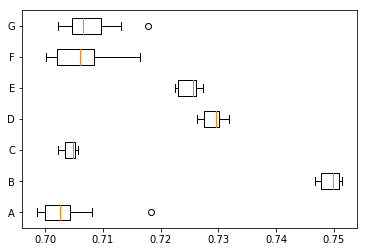

In [125]:
plt.boxplot(accuracy, vert=False, labels=['A','B','C','D','E','F','G'])